# **Projeto final da disciplina de Ciência dos Dados - Previsão de Taxa Selic**

Discente: Gisele Fonseca de Aguiar Silva

Programa de Pós Graduação em Administração UFPB - PPGA

**Contexto:**

A aplicação de Inteligência Artificial (IA) na macroeconomia tem se tornado cada vez mais relevante, permitindo analisar grandes volumes de dados econômicos, identificar padrões complexos e realizar previsões mais precisas sobre variáveis-chave, a Taxa Selic. Técnicas de IA, como aprendizado de máquina, podem melhorar modelos econômicos tradicionais ao considerar uma vasta gama de variáveis simultaneamente.

Esse projeto busca explorar o potencial da IA para prever e entender tendências econômicas, através da taxa SELIC. O uso de modelos preditivos, como ARIMA, pode fornecer insights valiosos para políticas monetárias mais eficazes e para decisões de investimento informadas.

A importância desse projeto reside na sua capacidade de melhorar a previsão econômica, oferecendo uma abordagem mais robusta para gestores financeiros, formuladores de políticas públicas e analistas de mercado, promovendo decisões mais assertivas em um ambiente econômico global cada vez mais dinâmico e interconectado.

Agora, vamos iniciar o projeto no Google Colab, implementando as primeiras análises e previsões.


# **1. Bibliotecas**

In [ ]:
# Instalar bibliotecas
!pip install pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.8 MB/s eta 0:00:00


In [ ]:
# Importar bibliotecas
import pandas as pd # manipulação e análise de dados
import pmdarima as pmd # modelo econometrico ARIMA
import google.generativeai as genai # biblioteca do google - fornece o modelo do Gemini
from google.colab import userdata # modulo do colab que trabalha com chaves de API
from io import StringIO # processa resposta do modelo
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# 2.Dados

Dados retirados do portal de dados do BC:

https://dadosabertos.bcb.gov.br/dataset/1178-taxa-de-juros---selic-anualizada-base-252

A primeira limpeza de dados foi feita no próprio arquivo excel, excluindo os dados anteriores a 04/01/1999 - No período de 1/7/1996 a 4/3/1999, o Copom fixava a Taxa Básica do Banco Central (TBC) e, a partir de 5/3/1999, com a extinção dessa, passou a divulgar a meta para a Taxa Selic para fins de política monetária. Portanto, na coluna “Meta Selic”, os valores da 1ª à 32ª reunião referem-se à TBC.

Fonte: https://www.bcb.gov.br/controleinflacao/historicotaxasjuros

In [ ]:
dados = pd.read_csv(
    filepath_or_buffer="/content/dados_1999_ATUAL.csv",
    sep=";",                  # Define o delimitador como ponto e vírgula
    names=["Data", "SELIC"],  # Define os nomes das colunas
    skiprows=1,               # Ignora a primeira linha se for cabeçalho indesejado
    parse_dates=["Data"],     # Converte a coluna 'Data' para datetime
    dayfirst=True,             # Define o formato como ano/mês/dia
    index_col="Data",          # Define 'Data' como índice
    converters={"SELIC": lambda x: float(x.replace(",", "."))}  # Converte SELIC para float
)

dados

,SELIC
Data,
1999-01-04,29.04
1999-01-05,28.93
1999-01-06,28.94
1999-01-07,29.01
1999-01-08,29.13
...,...
2024-11-05,10.65
2024-11-06,10.65
2024-11-07,11.15


In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6496 entries, 1999-01-04 to 2024-11-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SELIC   6496 non-null   float64
dtypes: float64(1)
memory usage: 101.5 KB


Note que estamos lidando com uma base de dados com 6496 linhas e o custo computacional torna-se maior, portanto o processamento mais lento. Para avitar isso, foi pensado em agrupar as variáveis mensalmente. O primeiro pensamento foi pelo primeiro dia em que a taxa aparece.

# Primeira base de dados analisada

In [ ]:
dados_mensal = dados.resample('M').first()
dados_mensal

<ipython-input-90-7532e1e10bee>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dados_mensal = dados.resample('M').first()


,SELIC
Data,
1999-01-31,29.04
1999-02-28,38.79
1999-03-31,38.98
1999-04-30,41.91
1999-05-31,31.90
...,...
2024-07-31,10.40
2024-08-31,10.40
2024-09-30,10.40


In [ ]:
#Estatísticas Descritivas Básicas
dados_mensal.describe()

,SELIC
count,311.000000
mean,12.765177
std,5.894150
min,1.900000
25%,9.025000
50%,12.150000
75%,16.165000
max,41.910000


In [ ]:
# Calcular a média e o desvio padrão de todas as colunas
media = dados_mensal.mean()
desvio_padrao = dados_mensal.std()

print(f'Média:\n{media}')
print(f'\nDesvio Padrão:\n{desvio_padrao}')

Média:
SELIC    12.765177
dtype: float64

Desvio Padrão:
SELIC    5.89415
dtype: float64


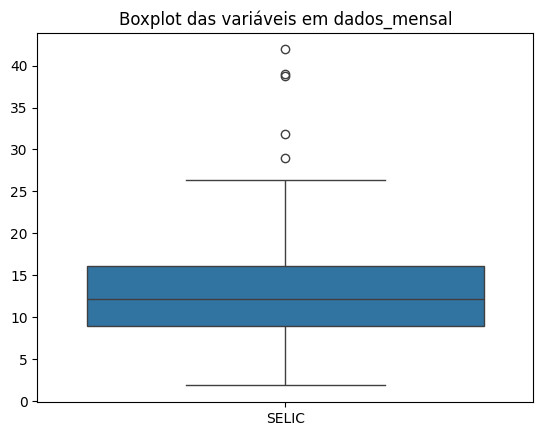

In [ ]:
# Boxplot para visualizar a dispersão
sns.boxplot(data=dados_mensal)
plt.title('Boxplot das variáveis em dados_mensal')
plt.show() #ajuda a visualizar a dispersão dos dados e identificar outliers

# **Análise Diagnóstica (Por Que os Dados se Comportam Dessa Forma?):**

Busca entender as causas do comportamento dos dados, observando padrões sazonais, tendências e variações

Tendência: direção geral dos dados ao longo do tempo.

Sazonalidade: padrões que se repetem em intervalos regulares.

Resíduo: variações que não podem ser explicadas por tendência ou sazonalidade.


In [ ]:
#Analise diagnóstica
from statsmodels.tsa.seasonal import seasonal_decompose

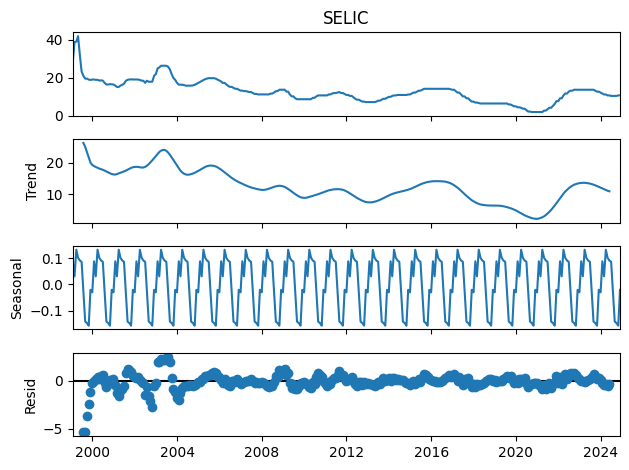

In [ ]:
# Decomposição da série temporal
decomposicao = seasonal_decompose(dados_mensal['SELIC'], model='additive', period=12)
decomposicao.plot()
plt.show()

# **3. Modelagem Preditiva**

A primeira parte é referente ao treino de uma parte da base (amostra) de dados e a segunda é para comparação

# Modelo econométrico

ARIMA

ARIMA significa média móvel integrada autorregressiva (Autoregressive Integrated Moving Average) e é uma técnica para análise de séries temporais e forecasting de possíveis valores futuros de uma série temporal.

Fonte: https://www.ibm.com/br-pt/topics/arima-model

In [ ]:
# Amostra de teste

h = 12 # referente ao ano
dados_teste = dados_mensal.tail(h).copy()
dados_teste

,SELIC
Data,
2023-12-31,12.15
2024-01-31,11.65
2024-02-29,11.15
2024-03-31,11.15
2024-04-30,10.65
2024-05-31,10.65
2024-06-30,10.40
2024-07-31,10.40
2024-08-31,10.40


In [ ]:
# Amostra de treino
dados_treino = dados_mensal.iloc[0:-h] #seleciona da linha 0 até a anterior apresentada no modelo anterior
dados_treino

,SELIC
Data,
1999-01-31,29.04
1999-02-28,38.79
1999-03-31,38.98
1999-04-30,41.91
1999-05-31,31.90
...,...
2023-07-31,13.65
2023-08-31,13.65
2023-09-30,13.15


In [ ]:
# Estimar o modelo automatizado ARIMA
previsao_arima = pmd.auto_arima(y = dados_treino.SELIC, m = h).predict(h).rename('ARIMA').to_frame()
previsao_arima

,ARIMA
2023-12-31,12.410555
2024-01-31,12.769205
2024-02-29,13.158850
2024-03-31,13.146812
2024-04-30,12.865248
2024-05-31,12.700077
2024-06-30,12.796313
2024-07-31,12.971871
2024-08-31,13.012429
2024-09-30,12.913926


In [ ]:
# Reseta o índice para transformar o índice atual em uma coluna nomeada "Data"
previsao_arima = previsao_arima.reset_index()

# Renomeia a coluna do índice para "Data"
previsao_arima.rename(columns={"index": "Data"}, inplace=True)

# Configura "Data" como o índice novamente
previsao_arima.set_index("Data", inplace=True)

previsao_arima


,ARIMA
Data,
2023-12-31,12.410555
2024-01-31,12.769205
2024-02-29,13.158850
2024-03-31,13.146812
2024-04-30,12.865248
2024-05-31,12.700077
2024-06-30,12.796313
2024-07-31,12.971871
2024-08-31,13.012429


# **4. Modelo de IA**

O uso da IA Gemini, uma ferramenta gratuita e acessível do Google AI Studio, traz algumas vantagens estratégicas na previsão da taxa SELIC, especialmente para um projeto em que estamos explorando métodos de IA para análise macroeconômica. Uma das razões principais é que o modelo Gemini utiliza uma grande quantidade de parâmetros e treinamento em dados de diversos domínios, permitindo capturar padrões complexos e não lineares nas séries temporais econômicas que modelos tradicionais, como o ARIMA, podem não captar tão bem.



In [ ]:
# usando o AI Studio - Gemini Google
# token (acesse https://ai.google.dev/gemini-api/docs/api-key
genai.configure(api_key = userdata.get("GEMINI_API_KEY"))

In [ ]:
# Envia arquivo CSV para API do Google
arquivo = genai.upload_file("dados_mensal_1999.csv")

In [ ]:
# Define prompt
data_previsao = dados_treino.index.max().strftime("%B 15, %Y")
periodo_previsao = dados_teste.index[[0, 11]].strftime("%B %Y").to_list()

prompt = f"""
Assume that you are in {data_previsao}.
Please give me your best forecast of Selic Target Interest Rate for Brazil,
measured in % per annum and published by Banco Central do Brasil, for
{periodo_previsao[0]} to {periodo_previsao[1]}.
Use the historical Selic Target Interest Rate data from the attached CSV file
named "dados_mensal_1999.csv", where "SELIC" is the target column and "date" is
the date column. Please give me numeric values for these forecasts, in a CSV like
format with a header, and nothing more. Do not use any information that was not
available to you as of {data_previsao} to formulate these forecasts.
"""
print(prompt)


Assume that you are in November 15, 2023.
Please give me your best forecast of Selic Target Interest Rate for Brazil,
measured in % per annum and published by Banco Central do Brasil, for
December 2023 to November 2024.
Use the historical Selic Target Interest Rate data from the attached CSV file
named "dados_mensal_1999.csv", where "SELIC" is the target column and "date" is
the date column. Please give me numeric values for these forecasts, in a CSV like
format with a header, and nothing more. Do not use any information that was not
available to you as of November 15, 2023 to formulate these forecasts.



In [ ]:
# Define modelo LLM e envia prompt
modelo_ia = genai.GenerativeModel(model_name = "gemini-1.5-pro", generation_config = {"temperature": 0.1})
resposta_ia = modelo_ia.generate_content([prompt, arquivo])

# Imprime resposta do modelo
print(resposta_ia.text)

Date,SELIC
2023-12-31,11.75
2024-01-31,11.75
2024-02-29,11.75
2024-03-31,11.75
2024-04-30,11.75
2024-05-31,11.75
2024-06-30,11.25
2024-07-31,10.75
2024-08-31,10.25
2024-09-30,9.75
2024-10-31,9.25
2024-11-30,8.75



In [ ]:
# Converte texto para tabela
previsao_ia = pd.read_csv(
    filepath_or_buffer = StringIO(resposta_ia.text),
    names = ["date", "Gemini"],
    converters = {"date": pd.to_datetime},
    index_col = "date",
    skiprows = 1
    )
previsao_ia

,Gemini
date,
2023-12-31,11.75
2024-01-31,11.75
2024-02-29,11.75
2024-03-31,11.75
2024-04-30,11.75
2024-05-31,11.75
2024-06-30,11.25
2024-07-31,10.75
2024-08-31,10.25


5. Avaliação de erros

In [ ]:
# Junta dados observados e de previsão
tabela_previsao = (
    dados_mensal
    .tail(h*10)
    .join(other = [previsao_arima, previsao_ia], how = "outer")
    .assign(Ensemble = lambda x: (x.ARIMA + x.Gemini) / 2)
    .dropna()
)
tabela_previsao.tail(h)

,SELIC,ARIMA,Gemini,Ensemble
2023-12-31,12.15,12.410555,11.75,12.080278
2024-01-31,11.65,12.769205,11.75,12.259602
2024-02-29,11.15,13.158850,11.75,12.454425
2024-03-31,11.15,13.146812,11.75,12.448406
2024-04-30,10.65,12.865248,11.75,12.307624
2024-05-31,10.65,12.700077,11.75,12.225038
2024-06-30,10.40,12.796313,11.25,12.023156
2024-07-31,10.40,12.971871,10.75,11.860935
2024-08-31,10.40,13.012429,10.25,11.631215
2024-09-30,10.40,12.913926,9.75,11.331963


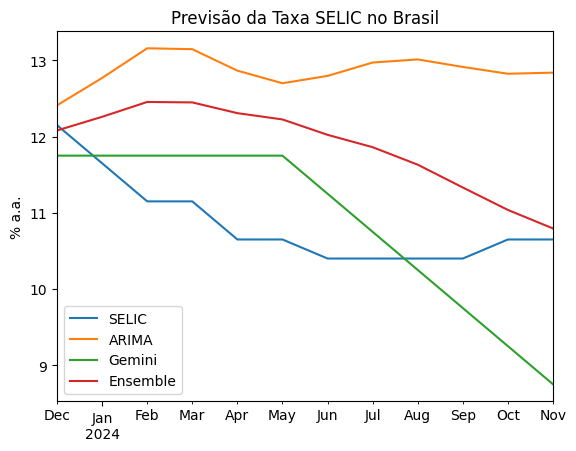

In [ ]:
# Avalia erro visualmente
tabela_previsao.plot(
    title = "Previsão da Taxa SELIC no Brasil",
    xlabel = "",
    ylabel = "% a.a."
    );

In [ ]:
previsoes = (
    dados_mensal
    .join(other = [previsao_arima, previsao_ia], how = "outer")
    .assign(Ensemble = lambda x: (x.ARIMA + x.Gemini) / 2)

)
previsoes

,SELIC,ARIMA,Gemini,Ensemble
1999-01-31,29.04,NaN,NaN,NaN
1999-02-28,38.79,NaN,NaN,NaN
1999-03-31,38.98,NaN,NaN,NaN
1999-04-30,41.91,NaN,NaN,NaN
1999-05-31,31.90,NaN,NaN,NaN
...,...,...,...,...
2024-07-31,10.40,12.971871,10.75,11.860935
2024-08-31,10.40,13.012429,10.25,11.631215
2024-09-30,10.40,12.913926,9.75,11.331963
2024-10-31,10.65,12.824643,9.25,11.037321


<Axes: >

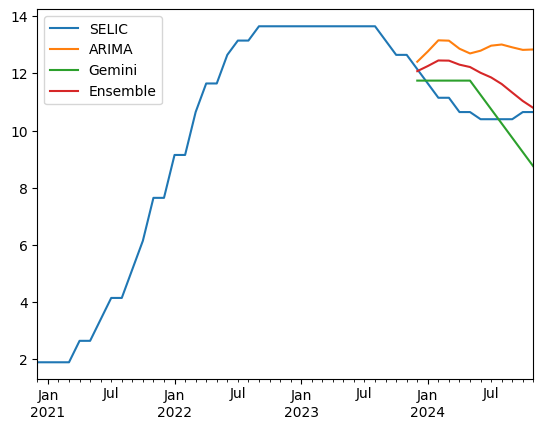

In [ ]:
previsoes.tail(48).plot()

<Axes: >

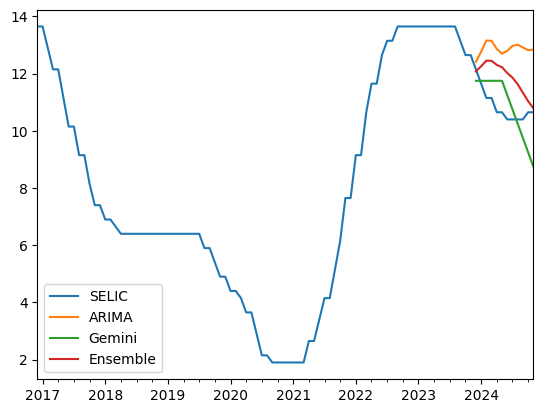

In [ ]:
previsoes.tail(96).plot()

In [ ]:
# Avalia erro numéricamente
erros_previsao = (
    tabela_previsao
    .dropna()
    .assign(
        erro_arima = lambda x: x.SELIC - x.ARIMA,
        erro_gemini = lambda x: x.SELIC - x.Gemini,
        erro_ensemble = lambda x: x.SELIC - x.Ensemble
    )
)
erros_previsao

,SELIC,ARIMA,Gemini,Ensemble,erro_arima,erro_gemini,erro_ensemble
2023-12-31,12.15,12.410555,11.75,12.080278,-0.260555,0.40,0.069722
2024-01-31,11.65,12.769205,11.75,12.259602,-1.119205,-0.10,-0.609602
2024-02-29,11.15,13.158850,11.75,12.454425,-2.008850,-0.60,-1.304425
2024-03-31,11.15,13.146812,11.75,12.448406,-1.996812,-0.60,-1.298406
2024-04-30,10.65,12.865248,11.75,12.307624,-2.215248,-1.10,-1.657624
2024-05-31,10.65,12.700077,11.75,12.225038,-2.050077,-1.10,-1.575038
2024-06-30,10.40,12.796313,11.25,12.023156,-2.396313,-0.85,-1.623156
2024-07-31,10.40,12.971871,10.75,11.860935,-2.571871,-0.35,-1.460935
2024-08-31,10.40,13.012429,10.25,11.631215,-2.612429,0.15,-1.231215
2024-09-30,10.40,12.913926,9.75,11.331963,-2.513926,0.65,-0.931963


In [ ]:
# Calcula métricas de erro
print(f"Erro médio do ARIMA é: {erros_previsao.erro_arima.mean().round(3)}")
print(f"Erro médio do Gemini é: {erros_previsao.erro_gemini.mean().round(3)}")
print(f"Erro médio do Ensemble é: {erros_previsao.erro_ensemble.mean().round(3)}")

Erro médio do ARIMA é: -2.009
Erro médio do Gemini é: -0.017
Erro médio do Ensemble é: -1.013


# RESULTADOS:

Note que o erro do ARIMA foi gritante. Achei estranho e resolvi mudar a base de dados usada. Ao invés de utilizar o primeiro valor do mês, decidi utilizar a mediana do mês.

# **Base de dados ajustada pela mediana**

In [ ]:
dados_mensal_2 = dados.resample('M').median()
dados_mensal_2

<ipython-input-106-f6681f77a2b8>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dados_mensal_2 = dados.resample('M').median()


,SELIC
Data,
1999-01-31,29.97
1999-02-28,38.99
1999-03-31,44.92
1999-04-30,33.94
1999-05-31,26.94
...,...
2024-07-31,10.40
2024-08-31,10.40
2024-09-30,10.40


# Análise Descritiva

In [ ]:
dados_mensal_2.describe()

,SELIC
count,311.000000
mean,12.754357
std,5.848276
min,1.900000
25%,9.150000
50%,12.150000
75%,16.230000
max,44.920000


In [ ]:
media = dados_mensal_2.mean()
desvio_padrao = dados_mensal_2.std()

print(f'Média:\n{media}')
print(f'\nDesvio Padrão:\n{desvio_padrao}')

Média:
SELIC    12.754357
dtype: float64

Desvio Padrão:
SELIC    5.848276
dtype: float64


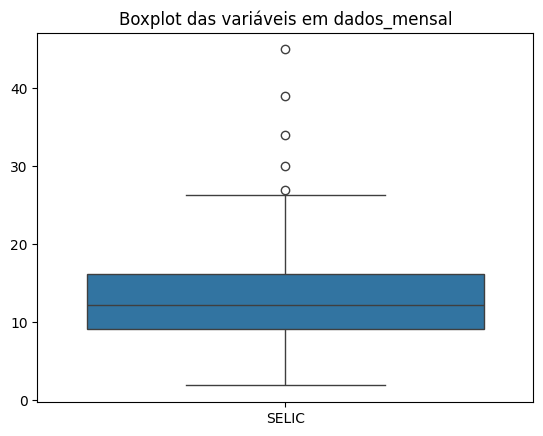

In [ ]:
# Boxplot para visualizar a dispersão
sns.boxplot(data=dados_mensal_2)
plt.title('Boxplot das variáveis em dados_mensal')
plt.show()

# Análise Diagnóstica

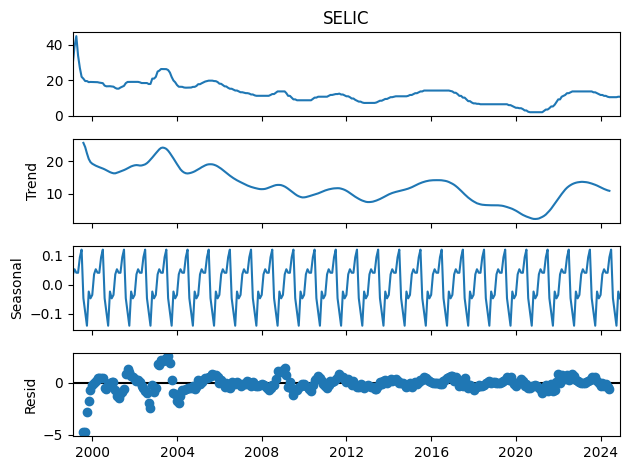

In [ ]:
# Decomposição da série temporal
decomposicao = seasonal_decompose(dados_mensal_2['SELIC'], model='additive', period=12)  # Ajuste o período conforme necessário
decomposicao.plot()
plt.show()

In [ ]:
# Amostra de teste

h = 12 # referente ao ano
dados_teste_2 = dados_mensal_2.tail(h).copy()
dados_teste_2

,SELIC
Data,
2023-12-31,11.65
2024-01-31,11.65
2024-02-29,11.15
2024-03-31,11.15
2024-04-30,10.65
2024-05-31,10.40
2024-06-30,10.40
2024-07-31,10.40
2024-08-31,10.40


In [ ]:
# Amostra de treino
dados_treino_2 = dados_mensal_2.iloc[0:-h] #seleciona da linha 0 até a anterior apresentada no modelo anterior
dados_treino_2

,SELIC
Data,
1999-01-31,29.97
1999-02-28,38.99
1999-03-31,44.92
1999-04-30,33.94
1999-05-31,26.94
...,...
2023-07-31,13.65
2023-08-31,13.15
2023-09-30,13.15


In [ ]:
# Estimar o modelo automatizado ARIMA
previsao_arima_2 = pmd.auto_arima(y = dados_treino_2.SELIC, m = h).predict(h).rename('ARIMA').to_frame().reset_index()


# Renomeia a coluna do índice para "Data"
previsao_arima_2.rename(columns={"index": "Data"}, inplace=True)

# Configura "Data" como o índice novamente
previsao_arima_2.set_index("Data", inplace=True)

In [ ]:
previsao_arima_2

,ARIMA
Data,
2023-12-31,11.820600
2024-01-31,11.890686
2024-02-29,11.702435
2024-03-31,11.635473
2024-04-30,11.486577
2024-05-31,11.231807
2024-06-30,11.221078
2024-07-31,11.143340
2024-08-31,11.110345


In [ ]:
# Junta dados observados e de previsão
tabela_previsao_2 = (
    dados_mensal_2
    .tail(h*10)
    .join(other = [previsao_arima_2, previsao_ia], how = "outer")
    .assign(Ensemble = lambda x: (x.ARIMA + x.Gemini) / 2)
    .dropna()
)
tabela_previsao_2.tail(h)

,SELIC,ARIMA,Gemini,Ensemble
2023-12-31,11.65,11.820600,11.75,11.785300
2024-01-31,11.65,11.890686,11.75,11.820343
2024-02-29,11.15,11.702435,11.75,11.726217
2024-03-31,11.15,11.635473,11.75,11.692737
2024-04-30,10.65,11.486577,11.75,11.618288
2024-05-31,10.40,11.231807,11.75,11.490904
2024-06-30,10.40,11.221078,11.25,11.235539
2024-07-31,10.40,11.143340,10.75,10.946670
2024-08-31,10.40,11.110345,10.25,10.680173
2024-09-30,10.40,11.120285,9.75,10.435142


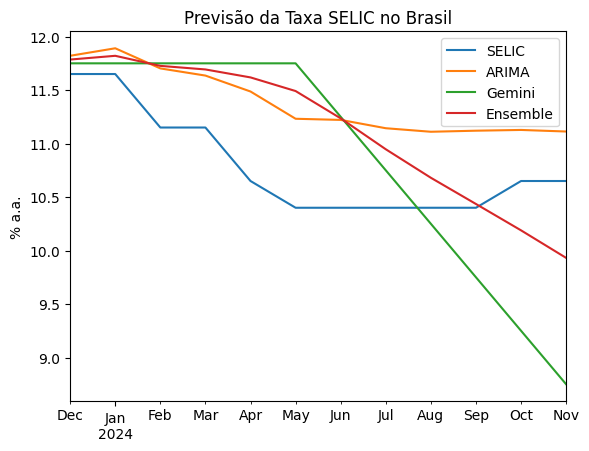

In [ ]:
# Avalia erro visualmente
tabela_previsao_2.plot(
    title = "Previsão da Taxa SELIC no Brasil",
    xlabel = "",
    ylabel = "% a.a."
    );

# Análise apenas entre nosso modelo e o comportamento real da taxa Selic

In [ ]:
# Junta dados observados e de previsão
tabela_previsao_3 = (
    dados_mensal_2
    .tail(h*10)
    .join(other = [previsao_arima_2], how = "outer")
    .dropna()
)
tabela_previsao_3.tail(h)

,SELIC,ARIMA
Data,,
2023-12-31,11.65,11.820600
2024-01-31,11.65,11.890686
2024-02-29,11.15,11.702435
2024-03-31,11.15,11.635473
2024-04-30,10.65,11.486577
2024-05-31,10.40,11.231807
2024-06-30,10.40,11.221078
2024-07-31,10.40,11.143340
2024-08-31,10.40,11.110345


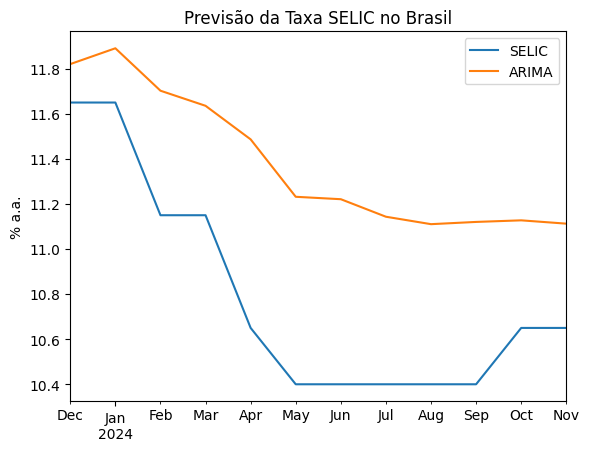

In [ ]:
# Avalia erro visualmente
tabela_previsao_3.plot(
    title = "Previsão da Taxa SELIC no Brasil",
    xlabel = "",
    ylabel = "% a.a."
    );

# Análises Descritivas dataframe tabela_previsao_3

In [ ]:
# Estatísticas descritivas básicas
tabela_previsao_3.describe()


,SELIC,ARIMA
count,12.000000,12.000000
mean,10.795833,11.383549
std,0.482163,0.303628
min,10.400000,11.110345
25%,10.400000,11.125560
50%,10.650000,11.226443
75%,11.150000,11.652214
max,11.650000,11.890686


In [ ]:
# Medidas de dispersão: variância e desvio padrão
tabela_previsao_3.var()
tabela_previsao_3.std()

,0
SELIC,0.482163
ARIMA,0.303628


In [ ]:
# Avalia erro numéricamente
erros_previsao_3 = (
    tabela_previsao_3
    .dropna()
    .assign(erro_arima = lambda x: x.SELIC - x.ARIMA,)
)
erros_previsao_3

,SELIC,ARIMA,erro_arima
Data,,,
2023-12-31,11.65,11.820600,-0.170600
2024-01-31,11.65,11.890686,-0.240686
2024-02-29,11.15,11.702435,-0.552435
2024-03-31,11.15,11.635473,-0.485473
2024-04-30,10.65,11.486577,-0.836577
2024-05-31,10.40,11.231807,-0.831807
2024-06-30,10.40,11.221078,-0.821078
2024-07-31,10.40,11.143340,-0.743340
2024-08-31,10.40,11.110345,-0.710345


In [ ]:
# Calcula métricas de erro
print(f"Erro médio do ARIMA é: {erros_previsao_3.erro_arima.mean().round(3)}")

Erro médio do ARIMA é: -0.588
